1. 修改了训练数据大小，70000

2. 修改了2处公式：

    ①第三项损失写成正确的写法，以前没有考虑后验的值KL(q)
    
    ②第二项：+log10.
    
3. 修改了batch_size=128，和latent_dim=32


In [6]:
#! -*- coding: utf-8 -*-

import numpy as np
from keras.layers import *
from keras.models import Model
from keras import backend as K
import imageio, os
from keras.datasets import mnist
# from keras.datasets import fashion_mnist as mnist

In [7]:
batch_size = 128
latent_dim = 32
epochs = 50
num_classes = 10
img_dim = 28
filters = 16
intermediate_dim = 256

In [8]:
# 加载MNIST数据集
(x_train, y_train_), (x_test, y_test_) = mnist.load_data()
train_data = np.vstack([x_train,x_test])
train_labels = np.hstack([y_train_,y_test_])
train_data = train_data.astype('float32') / 255.
train_data = train_data.reshape((-1, img_dim, img_dim, 1)) # (60000,28,28,1)

In [9]:
# 搭建模型
x = Input(shape=(img_dim, img_dim, 1)) # (28,28,1)
h = x

for i in range(2):
    filters *= 2
    h = Conv2D(filters=filters,
               kernel_size=3,
               strides=2,
               padding='same')(h)
    h = LeakyReLU(0.2)(h)
    h = Conv2D(filters=filters,
               kernel_size=3,
               strides=1,
               padding='same')(h)
    h = LeakyReLU(0.2)(h)

h_shape = K.int_shape(h)[1:] # (14,14,64)
h = Flatten()(h)
z_mean = Dense(latent_dim)(h)  # p(z|x)的均值
z_log_var = Dense(latent_dim)(h)  # p(z|x)的方差

encoder = Model(x, z_mean)  # 通常认为z_mean就是所需的隐变量编码

z = Input(shape=(latent_dim,))
h = z
h = Dense(np.prod(h_shape))(h)
h = Reshape(h_shape)(h)

for i in range(2):
    h = Conv2DTranspose(filters=filters,
                        kernel_size=3,
                        strides=1,
                        padding='same')(h)
    h = LeakyReLU(0.2)(h)
    h = Conv2DTranspose(filters=filters,
                        kernel_size=3,
                        strides=2,
                        padding='same')(h)
    h = LeakyReLU(0.2)(h)
    filters //= 2

x_recon = Conv2DTranspose(filters=1,
                          kernel_size=3,
                          activation='sigmoid',
                          padding='same')(h)

decoder = Model(z, x_recon)  # 解码器 (B,28,28,1)
generator = decoder

z = Input(shape=(latent_dim,))
y = Dense(intermediate_dim, activation='relu')(z)
y = Dense(num_classes, activation='softmax')(y)

classfier = Model(z, y)  # 隐变量分类器


# 重参数技巧
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(z_log_var / 2) * epsilon


# 重参数层，相当于给输入加入噪声
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
x_recon = decoder(z)
y = classfier(z)


class Gaussian(Layer):
    """这是个简单的层，定义q(z|y)中的均值参数，每个类别配一个均值。
    然后输出“z - 均值”，为后面计算loss准备。
    """

    def __init__(self, num_classes, **kwargs):
        self.num_classes = num_classes
        super(Gaussian, self).__init__(**kwargs)

    def build(self, input_shape):
        latent_dim = input_shape[-1]
        self.mean = self.add_weight(name='mean',
                                    shape=(self.num_classes, latent_dim),
                                    initializer='zeros')

    def call(self, inputs):
        z = inputs  # z.shape=(batch_size, latent_dim)
        z = K.expand_dims(z, 1)
        return z - K.expand_dims(self.mean, 0) # (B,1,latent_dim) - (1,K,latent_dim) = (B,K,latent_dim)

    def compute_output_shape(self, input_shape):
        return (None, self.num_classes, input_shape[-1])


gaussian = Gaussian(num_classes)
z_prior_mean = gaussian(z)

# 建立模型
vae = Model(x, [x_recon, z_prior_mean, y])


# 定义loss
z_mean = K.expand_dims(z_mean, 1)
z_log_var = K.expand_dims(z_log_var, 1)

z = K.expand_dims(z, 1) # (B,1,latent_dim)
z_post_mean = 0.5 * (K.square(z - z_mean)/(1e-8+K.exp(z_log_var))) # (B,1,latent_dim)

lamb = 2.5  # 这是重构误差的权重，它的相反数就是重构方差，越大意味着方差越小。
xent_loss = 0.5 * K.mean((x - x_recon) ** 2, 0)

kl_loss = - 0.5 * (z_log_var - K.square(z_prior_mean)) - z_post_mean  # (B,K,latent_dim)
kl_loss = K.mean(K.batch_dot(K.expand_dims(y, 1), kl_loss), 0)

cat_loss = K.mean(y * (K.log(y + K.epsilon())+K.log(10.)), 0)

vae_loss = lamb * K.sum(xent_loss) + K.sum(kl_loss) + K.sum(cat_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

history = vae.fit(train_data,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 14, 14, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 32)   9248        leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
leaky_re_l

In [10]:
vae.save_weights('./Vade_4')
# vae.load_weights('./Vade')

In [11]:
means = K.eval(gaussian.mean) # (K,latent_dim)
x_train_encoded = encoder.predict(train_data) # (70000,latent_dim)
y_train_pred = classfier.predict(x_train_encoded).argmax(axis=1) # (70000,)

def cluster_save_sample(path, category=0):
    """观察被模型聚为同一类的样本
    """
    n = 8
    figure = np.zeros((img_dim * n, img_dim * n))
    idxs = np.where(y_train_pred == category)[0] # 找到预测结果为category的样本
    for i in range(n):
        for j in range(n):
            digit = train_data[np.random.choice(idxs)] # 随机选择一个该类别样本
            digit = digit.reshape((img_dim, img_dim))
            figure[i * img_dim: (i + 1) * img_dim,
            j * img_dim: (j + 1) * img_dim] = digit
    imageio.imwrite(path, figure * 255)


def random_save_sample(path, category=0, std=1):
    """按照聚类结果进行条件随机生成
    """
    n = 8
    figure = np.zeros((img_dim * n, img_dim * n))
    for i in range(n):
        for j in range(n):
            noise_shape = (1, latent_dim)
            z_sample = np.array(np.random.randn(*noise_shape)) * std + means[category]
            x_recon = generator.predict(z_sample)
            digit = x_recon[0].reshape((img_dim, img_dim))
            figure[i * img_dim: (i + 1) * img_dim,
            j * img_dim: (j + 1) * img_dim] = digit
    imageio.imwrite(path, figure * 255)


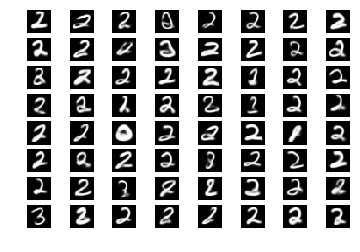

In [8]:
import matplotlib.pyplot as plt 
def cluster_sample_plot(category=0):
    """观察被模型聚为同一类的样本
    """
    n = 8
    idxs = np.where(y_train_pred == category)[0] # 找到预测结果为category的样本
    for i in range(n**2):
        plt.subplot(n,n,i+1)
        digit = x_train[np.random.choice(idxs)]
        digit = digit.reshape((img_dim, img_dim))
        plt.imshow(digit,cmap='gray')
        plt.axis('off')
    plt.show()

def random_sample_plot(category=0, std=1):
    """按照聚类结果进行条件随机生成
    """
    n = 8
    for i in range(n**2):
        plt.subplot(n,n,i+1)
        noise_shape = (1, latent_dim)
        z_sample = np.array(np.random.randn(*noise_shape)) * std + means[category]
        x_recon = generator.predict(z_sample)
        digit = x_recon[0].reshape((img_dim, img_dim))
        plt.imshow(digit,cmap='gray')
        plt.axis('off')
    plt.show()

random_sample_plot(0)

In [12]:
if not os.path.exists('samples_4'):
    os.mkdir('samples_4')

for i in range(10):
    cluster_save_sample(u'samples_4/聚类类别_%s.png' % i, i)
    random_save_sample(u'samples_4/类别采样_%s.png' % i, i)

right = 0.
for i in range(10):
    _ = np.bincount(train_labels[y_train_pred == i])
    right += _.max()

print('train acc: %s' % (right / len(train_labels)))

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [9.886117988539828e-27, 254.67806607484818]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [5.747394935708842e-19, 254.14875447750092]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [1.2228249433420498e-16, 254.41124439239502]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 t

train acc: 0.9251857142857143


In [27]:
print(train_labels[y_train_pred==0].shape)  # 预测为0的那些样本
num = np.bincount(train_labels[y_train_pred==0]).max()
num

(6730,)


6365

In [13]:
loss = history.history['loss']
loss

[51.212550375802174,
 35.27572568620954,
 33.87113957606724,
 32.98625581708636,
 32.41023573957171,
 31.848481389944894,
 31.45041998901367,
 31.130771995762416,
 30.88186677987235,
 30.692778616768972,
 30.489563274274552,
 30.361130705043248,
 30.203241747174943,
 30.11059484514509,
 30.00172787388393,
 29.942088690621514,
 29.85317479727609,
 29.777540001569477,
 29.69155033307757,
 29.678725383649553,
 29.55488936505999,
 29.51168300955636,
 29.465474169921876,
 29.431237518310546,
 29.403596793910435,
 29.334010010637556,
 29.30214189627511,
 29.243882059151787,
 29.21120871800014,
 29.191622400774275,
 29.132644717843192,
 29.132379098074775,
 29.085899455479215,
 29.06565959472656,
 29.047694710867745,
 29.003841178240094,
 29.00058410121373,
 28.9640587890625,
 28.928677950177875,
 28.912904753766743,
 28.88954177507673,
 28.88617374093192,
 28.838214332362583,
 28.834772697666715,
 28.82291618521554,
 28.78850815560477,
 28.753077968052455,
 28.76571682652065,
 28.71207636631

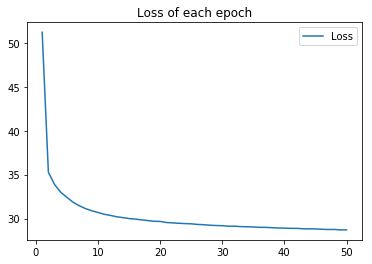

In [16]:
import matplotlib.pyplot as plt
plt.plot(range(1,51),loss,label='Loss')
plt.title('Loss of each epoch')
plt.legend()
plt.show()

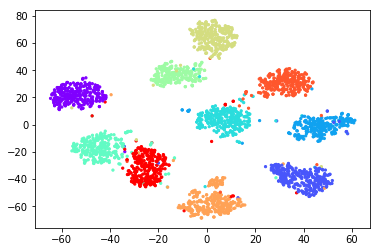

In [17]:
# 画图
from sklearn.manifold import TSNE
tsne = TSNE()
plt_size =3000
i = 1 
z = x_train_encoded[plt_size*i:plt_size*(i+1),:]
z = tsne.fit_transform(z)
# z.shape=(3000,2)
plt.scatter(z[:, 0], z[:, 1], c=train_labels[plt_size*i:plt_size*(i+1)], cmap='rainbow',s=5)

plt.show()

19
